In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load the CSV files
# The CSV files contain the input parameters
stations = pd.read_csv('stations.csv') # Station and their chainage
curves = pd.read_csv('curves.csv') # Curves data including start, end, radius
gradients = pd.read_csv('gradients.csv') # Gradient data including start, end
speed_restrictions = pd.read_csv('sr.csv') # Speed restriction associated with curve

# Load the train parameters CSV file
train_params = pd.read_csv('train_parameters.csv')# Train parameters

#print(speed_restrictions.columns)
#print(curves.columns)


In [3]:
# Convert the 'Value' column to a dictionary for easy access
train_params_dict = pd.Series(train_params.Value.values, index=train_params.Parameter).to_dict()

# Create a dictionary to map radius to speed restriction
speed_limit_dict = pd.Series(speed_restrictions.Speed_Limit.values, index=speed_restrictions.Radius).to_dict()

# Extract values from the dictionary
acceleration = float(train_params_dict['Acceleration_rate_1'])
acceleration_switch = float(train_params_dict['Acceleration_rate_2'])
switch_speed = float(train_params_dict['Switch_speed'])
braking_deceleration = float(train_params_dict['Braking_rate'])
max_speed = float(train_params_dict['Maximum_speed'])  # Assuming the speed is in km/h, convert to m/s
static_friction = float(train_params_dict['Static_friction'])
rolling_resistance = float(train_params_dict['Rolling_resistance'])
air_resistance = float(train_params_dict['Air_resistance'])
mass = float(train_params_dict['Train_mass'])  # Train weight in tons
#power = float(train_params_dict['Power'])  # Power in kW
mc_mass = float(train_params_dict['MC_mass'])  # Motor car weight
tc_mass = float(train_params_dict['TC_mass'])  # Trailer Car weight
starting_resistance = float(train_params_dict['Starting_resistance'])  # Starting resistance of train
inertia_mass_m = float(train_params_dict['Inertia_mass_m'])  # Intertial coefficient of motor car
inertia_mass_t = float(train_params_dict['Inertia_mass_t'])  # Intertial coefficient of trailer car
motor_nos = float(train_params_dict['Motor_nos'])  # Number of driving motors in train


# Convert speeds from km/h to m/s
max_speed = max_speed * 1000 / 3600
switch_speed = switch_speed * 1000 / 3600

no_coasting = False # Flag for coasting, true if present

#print(f'static_friction:{static_friction},mass:{mass}')
#print(f'Acceleration 2:{acceleration_switch}')


In [4]:
def accelerate(speed, acceleration, max_speed, time_step=1):
    """
    Calculate the increased speed during coasting due to accelerating effort.

    Parameters:
    - speed (float): Current speed of the train (m/s).
    - acceleration (float): The acceleration rate.
    - time_step (float): Time over which to calculate the speed reduction (seconds). Default is 1 second.

    Returns:
    - float: The new reduced speed after applying friction forces.
    """
    #print(f'Speed:{speed}, Accel:{acceleration}')
    if speed + acceleration * time_step > max_speed:
        speed = max_speed
    else:
        speed += acceleration * time_step
    return speed


In [5]:
def brake(speed, braking, time_step=1):
    """
    Calculate the reduced speed during coasting due to braking effort.

    Parameters:
    - speed (float): Current speed of the train (m/s).
    - braking (float): The braking rate.
    - time_step (float): Time over which to calculate the speed reduction (seconds). Default is 1 second.

    Returns:
    - float: The new reduced speed after applying friction forces.
    """
    if speed - braking * time_step < 0:
        speed = 0
    else:
        speed -= braking * time_step
    return speed


In [6]:
def coast(speed, mass, static_friction, rolling_resistance, air_resistance, time_step=1):
    """
    Calculate the reduced speed during coasting due to friction forces.

    Parameters:
    - speed (float): Current speed of the train (m/s).
    - mass (float): Mass of the train (in tons).
    - static_friction (float): Static friction coefficient (N/ton).
    - rolling_resistance (float): Rolling resistance coefficient (N/ton/m/s).
    - air_resistance (float): Air resistance coefficient (N/ton/m^2/s^2).
    - time_step (float): Time over which to calculate the speed reduction (seconds). Default is 1 second.

    Returns:
    - float: The new reduced speed after applying friction forces.
    """

    if (no_coasting):
        return speed
        
    # Convert mass from tons to kg (1 ton = 1000 kg)
    mass_kg = mass * 1000

    # Calculate the total resistance (Davis equation)
    resistance = (static_friction + rolling_resistance * speed + air_resistance * speed**2) * mass

    # Calculate deceleration due to resistance (force/mass)
    deceleration = resistance / mass_kg  # in m/s²

    # Calculate the new speed after deceleration
    new_speed = speed - deceleration * time_step

    # Ensure the speed doesn't go below 0
    if new_speed < 0:
        new_speed = 0

    return new_speed

In [7]:
# Function to find the speed restriction at a given distance
def get_speed_restriction(distance):
    """
    Applies the Speed Restriction if the train is in SR zone.

    Parameters:
    - distance (float): The current position of the train wrt origin

    Returns:
    - float: If the Train is in SR zone, the speed is reduced to a specified restricted speed.
    """
    for i in range(len(curves)):
        start = curves.iloc[i]['Start']
        end = curves.iloc[i]['End']
        radius = curves.iloc[i]['Radius']
        
        # Check if the current distance falls within the curve zone
        if start <= distance <= end:
            # Return the speed restriction for the corresponding radius
            return speed_limit_dict.get(radius, None)  * 1000 / 3600 # Returns None if radius not found
    return None  # No speed restriction if distance is outside curve zones


***Stations Distances***

In [8]:
# Extract the chainage and station names
station_chainages = stations['Chainage'].values
station_names = stations['Station_Name'].values
#print(len(station_names))

# Calculate distances between consecutive stations
distances_between_stations = [station_chainages[i+1] - station_chainages[i] for i in range(len(station_chainages)-1)]

# Station data
#print("Stations and Chainages:\n")
#for i in range(len(station_chainages)):
#    print(f"{station_names[i]} \t {station_chainages[i]} meters")

# Stations inter distance
#print("\nDistances between stations:")
#for i in range(len(distances_between_stations)):
#    print(f" {station_names[i]} -- {station_names[i+1]}: \t\t\t{distances_between_stations[i]} meters")



***Run the Simulation***

***Operation Philosophy***

The train will be one of three modes

- **Acceleration mode**: The train accelerates to it's maximum speed
- **Coasting**: Tractive effort is withdrawn and the train travels on it's own inertia. It slows due to friction
- **Braking**: The train brakes on it's braking power

In [9]:
# Initialize simulation variables
time = 0
speed = 0
distance = 0
covered_distance = 0
time_log = []
speed_log = []

# Simulate the movement from station to station
for i in range(len(station_names)-1):
    start_station = station_chainages[i]
    end_station = station_chainages[i+1]
    segment_distance = end_station - start_station
    #print(f'Next Station: {segment_distance} Distance Covered: {covered_distance} Reset:{distance}')
    
    # Accelerate after leaving the station
    while distance < segment_distance:  # Accelerate
        if (speed >= switch_speed):
            acceleration_loop = acceleration_switch
        else:
            acceleration_loop = acceleration
        speed = accelerate(speed, acceleration_loop, max_speed, time_step=1)
        distance += speed
        #print(f'Speed:{speed} Distance:{distance}')
        if (speed >= max_speed):
            break
        else:
            time += 1
        time_log.append(time/60)
        speed_log.append(speed * 18 / 5)

    # Coast until speed drops to 80% of the max speed
    while distance < (segment_distance - max_speed**2/2/braking_deceleration):  # Coasting
        #print('coast')
        if speed > 0.8 * max_speed:
            speed = coast(speed, mass, static_friction, rolling_resistance, air_resistance, time_step=1)  # Coasting deceleration, assumed to be small
        else:
            speed = accelerate(speed, acceleration, max_speed, time_step=1)
        speed_limit = get_speed_restriction(covered_distance + distance)
        if speed_limit:
            speed = speed_limit
        distance += speed
        speed_check = coast(speed, mass, static_friction, rolling_resistance, air_resistance, time_step=1)
        #print(f'Check:{speed_check}, speed:{speed}')
        #print(f'Speed:{speed} Distance:{distance}')
        time += 1
        time_log.append(time/60)
        speed_log.append(speed * 18 / 5)
    
    # Brake before reaching the station
    while distance < segment_distance:  # Braking
        speed = brake(speed, braking_deceleration, time_step=1)
        distance += speed
        #print(f'Speed:{speed} Distance:{distance}')
        if (speed == 0):
            break
        else:
            time += 1
        time_log.append(time/60)
        speed_log.append(speed * 18 / 5)

    # Stop at the station for 30 seconds
    for _ in range(30):
        time += 1
        time_log.append(time/60)
        speed_log.append(0)

    covered_distance += segment_distance
    distance = 0
    speed = 0

#print(f'time:{time_log}')
#print(f'speed:{speed_log}')

***Motor Rating***

**Tractive Effort** = Tractive Effort at **Start** + Tractive Effort on **Rolling**

Rolling Tractive Effort = (**Tare weight** of Cars $\times$ **Inertial** Co-effecients) $\times$ **Acceleration**

Starting Tractive Effort = **Starting Resistance** $\times$ Train **weight**

Motor **Power Rating** = Tractive Effort $\times$ **Speed**

In [10]:
te_start = mass * starting_resistance / 1000 # Starting Effort in kN
te_rolling = (mass + 
              mc_mass * inertia_mass_m * 2 + 
             tc_mass * inertia_mass_t) * acceleration # Moving Effort
te_total = te_start + te_rolling # Total Effort
te_motor = te_total / motor_nos # Effort per Motor
motor_rating = te_motor * switch_speed  # Motor Rating

print(f'Required Tractive effort:{te_motor},\t Motor Rating:{motor_rating}')
#print(acceleration)

Required Tractive effort:27.530625,	 Motor Rating:305.8958333333333


***Average Speed***

In [11]:
# Calculate the average speed
total_distance = station_chainages[-1] - station_chainages[0]
average_speed = total_distance / time
print(f"A total distance of {total_distance/1000:.2f} Km was covered in {time/60:.2f} minutes.")
print(f"Average speed for the trip was: {average_speed*18/5:.2f} km/hr")


A total distance of 35.78 Km was covered in 34.60 minutes.
Average speed for the trip was: 62.04 km/hr


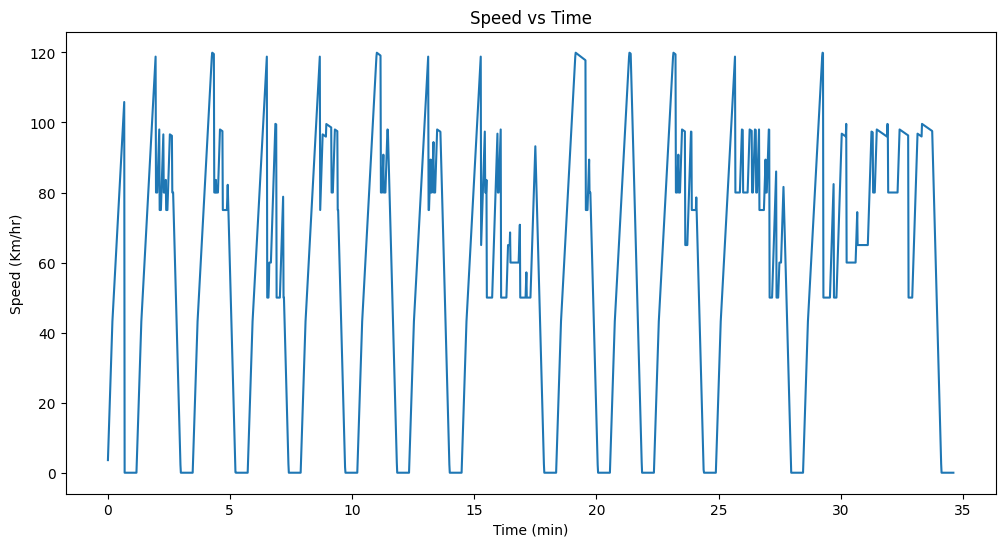

In [12]:
# Plot the speed vs time graph
fig = plt.figure(figsize=(12, 6))

plt.plot(time_log, speed_log)
plt.title('Speed vs Time')
plt.xlabel('Time (min)')
plt.ylabel('Speed (Km/hr)')
plt.show()



In [13]:
# Stations inter distance
print("Distances between stations:\n")
for i in range(len(distances_between_stations)):
    print(f" {station_names[i]} -- {station_names[i+1]}: \t\t\t{distances_between_stations[i]} meters")


Distances between stations:

 Point of beginning -- Nagole (Airport): 			670 meters
 Nagole (Airport) -- Alkapuri Jn: 			2370 meters
 Alkapuri Jn -- LB Nagar (Airport): 			2310 meters
 LB Nagar (Airport) -- Maitri Nagar: 			2120 meters
 Maitri Nagar -- Champapet Rd: 			2530 meters
 Champapet Rd -- DRDO: 			2120 meters
 DRDO -- Chandrayangutta: 			2090 meters
 Chandrayangutta -- Mailardevpally: 			3710 meters
 Mailardevpally -- Aramghar: 			2440 meters
 Aramghar -- New High Court: 			1499 meters
 New High Court -- Satamrai: 			2711 meters
 Satamrai -- Shamshabad: 			3926 meters
 Shamshabad -- RGIA: 			7282 meters


***Explanation***

The average speed of a metro train can be calculated by analyzing the phases of the journey: acceleration, cruising at max speed, and braking.

To derive the average speed, we can use the following logic:

1. **Acceleration Phase**: The train accelerates from 0 to maximum speed.
2. **Cruising Phase**: The train maintains the maximum speed until it begins braking.
3. **Coasting Phase**: The train's speed gradually decreases due to the deceleration caused by friction, which depends on the current speed.
4. **Braking Phase**: The train decelerates to 0 at the destination.

The total distance covered during acceleration and braking can be split up.

$\large t_a = \frac{m}{a}$, 

$\large t_b = \frac{m}{b}$


To account for friction during the cruising (now coasting) phase, we can incorporate the train resistance equation. The coasting phase will involve the train gradually decelerating due to the resistance force. The train resistance (friction) is commonly modeled using a quadratic or linear function of speed, such as:

$\large
F_r = A + Bv + Cv^2
$

Where:
- $ F_r $ is the total resistance (in Newtons).
- $ A $, $ B $, and $ C $ are coefficients for the train resistance (typically dependent on the type of train).
- $ v $ is the train's velocity during coasting.

**Hundai Rotem** for LTMRHL

$ \large R = 14.01 + 0.264 \times V + 0.00191 \times V^2 $

- R: Train Resistance in N/Ton
- V: Train Speed in Km/h

$\huge R = \frac{500}{r} $

- R: Curve Resistance in N/Ton
- r: Curve Radius in m

The equation for motion during the coasting phase will now take into account this resistance. The deceleration due to resistance can be computed using:

$\huge
a_{\text{coast}} = -\frac{F_r}{m_{\text{train}}}
$

Where:
- $ a_{\text{coast}} $ is the deceleration during coasting.
- $ m_{\text{train}} $ is the mass of the train.


Introducing curve and gradient resistance into the train's journey adds new complexities to the coasting and cruising phases. Here's how we'll incorporate these factors:

#### Curve Resistance:
- **Curve Resistance** occurs due to the curvature of the track. For a given curve, the additional resistance is calculated as:

$\huge
  R_{\text{curve}} = \frac{600}{\text{radius of the curve in meters}} 
$

#### Gradient Resistance:
- **Gradient Resistance** is the resistance caused by an incline or decline in the track. For a 1 in 100 gradient, the resistance is:

$\huge
  R_{\text{gradient}} = 9.81 \times \frac{1}{100} \times \text{mass of the train (in kg)}
$


The line of code:

```python
t_total = np.sqrt(2 * d / (a + b))
```

is used to calculate the total time required for the train to travel a given distance `d` if the train does not reach its maximum speed during acceleration or braking.

### Breakdown:

- `d`: The total distance to be traveled.
- `a`: The acceleration rate (in meters per second squared, m/s²).
- `b`: The braking rate (in meters per second squared, m/s²).

### Explanation:

This line is derived from the following scenario:

- If the train does not reach the maximum speed during the journey, the motion is purely controlled by the acceleration and braking phases.
- The train first accelerates at rate `a` and then decelerates (brakes) at rate `b` to stop at the destination. In this situation, the train never reaches its cruising (maximum) speed.

In such a case, the total time `t_total` required to travel the distance `d` can be calculated by using a simplified kinematic equation that accounts for both acceleration and braking phases.

1. **Kinematic equation for displacement (ignoring maximum speed)**:
   The total distance traveled under constant acceleration and braking is given by:

   
   $\huge
   d = \frac{1}{2} a t_{\text{accel}}^2 + \frac{1}{2} b t_{\text{brake}}^2
   $

   Since the train accelerates and brakes symmetrically (one phase follows the other), the total time can be treated as a function of both `a` and `b`. For simplicity, we assume:

   
   $\huge
   d = \frac{1}{2} (a + b) t_{\text{total}}^2
   $

3. **Rearranging the equation** to solve for `t_total`:

4. 
   $\huge
   t_{\text{total}} = \sqrt{\frac{2d}{a + b}}
  $

This equation assumes that the entire journey is a combination of acceleration and braking, with no constant-speed coasting phase. 

### Key Points:
- The `t_total` calculation is only valid when the train never reaches the maximum speed.
- The formula simplifies the process by treating the acceleration and braking phases together, assuming symmetrical motion. The distance is split between the acceleration and braking phases.


**Coasting Phase Logic**:

- The speed is  updated at each time step during the coasting phase.
- **Gradual Speed Reduction**: The speed is reduced continuously in the coasting phase as the train slows down due to friction.
- The velocity decreases based on the deceleration due to friction, which is computed using the train resistance equation at each time step.
- During this phase, if the speed falls below $ 0.9 × 𝑚 $, the train will re-accelerate until it reaches the maximum speed again  or until the segment distance is covered.
- We'll use a simple loop to check the speed at each time step during the coasting phase. If it drops below the threshold, acceleration is reapplied until the train returns to its maximum speed.


Additionaly in function: calculate_average_speed_with_reacceleration, the function now calculates how many times re-acceleration is triggered during the coasting phase and integrates that into the overall timing and speed profile.

1. **Curve and Gradient Handling**: Instead of assigning a single curve or gradient to a section, we'll calculate their effects cumulatively if there are overlapping curves or gradients.

2. **Resistance Calculations**: The calculate_cumulative_resistance() function computes the total resistances from all applicable curves and gradients at each segment.

The formula $P_{\text{required}} = R_{\text{total}} \times v $ is used to calculate the **power required** by a train to overcome various resistances while it is in motion. 

- **Power in Physics**:
  
   $
   P = F \times v
  $
  
   Where:
   - $ P $ is power,
   - $ F $ is the force (in this case, the total resistance),
   - $ v $ is the velocity (speed of the train).


### Example:

- If a train is moving at a speed of 20 m/s and the total resistance it encounters is 300 N, the power required to maintain that speed would be calculated as follows:
  
  $
  P_{\text{required}} = R_{\text{total}} \times v = 300 \, \text{N} \times 20 \, \text{m/s} = 6000 \, \text{W} 
  $

This means the train needs to produce at least 6000 watts (6 Kw) of power to maintain that speed against the resistance. If the power available from the train's motor is less than this, it will start to decelerate.